In [1]:
%pylab inline
from scipy.interpolate import interpn
from multiprocessing import Pool
from constant import * 
import warnings
import math
warnings.filterwarnings("ignore")
np.printoptions(precision=2)

Populating the interactive namespace from numpy and matplotlib


In [2]:
# wealth discretization 
ws = np.array([10,25,50,75,100,125,150,175,200,250,500,750,1000,1500,3000])
w_grid_size = len(ws)
# 401k amount discretization 
ns = np.array([1, 5, 10, 15, 25, 50, 100, 150, 400, 1000])
n_grid_size = len(ns)
# Mortgage amount
Ms = np.array([0.01*H,0.05*H,0.1*H,0.2*H,0.3*H,0.4*H,0.5*H,0.8*H]) * pt
M_grid_size = len(Ms)
points = (ws,ns,Ms)

In [3]:
import quantecon as qe
import timeit
mc = qe.MarkovChain(Ps)

#Vgrid = np.load("Vgrid_i.npy")
cgrid = np.load("cgrid" + str(H)+ ".npy")
bgrid = np.load("bgrid" + str(H)+ ".npy")
kgrid = np.load("kgrid" + str(H)+ ".npy")
qgrid = np.load("qgrid" + str(H)+ ".npy")

def action(t, x):
    w, n, M, e, s, z = x
    c = interpn(points, cgrid[:,:,:,e,s,z,t], x[:3], method = "nearest", bounds_error = False, fill_value = None)[0]
    b = interpn(points, bgrid[:,:,:,e,s,z,t], x[:3], method = "nearest", bounds_error = False, fill_value = None)[0]
    k = interpn(points, kgrid[:,:,:,e,s,z,t], x[:3], method = "nearest", bounds_error = False, fill_value = None)[0]
    q = interpn(points, qgrid[:,:,:,e,s,z,t], x[:3], method = "nearest", bounds_error = False, fill_value = None)[0]
    if q <= 0.75:
        q = 0.5
    else:
        q = 1
    return (c,b,k,q)


def transition(x, a, t, s_next):
    '''
    Input: state and action and time
    Output: possible future states and corresponding probability 
    '''
    w, n, M, e, s, z = x
    c,b,k,q = a
    # variables used to collect possible states and probabilities
    x_next = []
    m = M/D[T_max-t]
    M_next = M*(1+rh) - m
    # transition of z
    if z == 1:
        z_next = 1
    else:
        if k == 0:
            z_next = 0
        else:
            z_next = 1 
    
    n_next = gn(t, n, x, r_k[s_next])
    w_next =  b*(1+r_b[int(s)]) + k*(1+r_k[s_next])
    if t >= T_R:
        return [w_next, n_next, M_next, 0, s_next, z_next]
    else:
        if e == 1:
            for e_next in [0,1]:
                x_next.append([w_next, n_next, M_next, e_next, s_next, z_next])
            prob_next = [Pe[s,e], 1 - Pe[s,e]]
        else:
            for e_next in [0,1]:
                x_next.append([w_next, n_next, M_next, e_next, s_next, z_next])
            prob_next = [1-Pe[s,e], Pe[s,e]]
        return x_next[np.random.choice(len(prob_next), 1, p = prob_next)[0]]

In [4]:
'''
    Start with:
    Ms = H * 0.8 * 0.25
    w = 20
    n  = 0
    e = 1
    s = 1
    z = 0 
    1000 agents for 1 economy, 100 economies. 
    
    use numpy array to contain the variable change:
    
    wealth, rFund, Mortgage, employment, sState, participation
    salary, consumption, hConsumption, bond, stock, hPercentage, 
    life. Shape: (T_max-T_min, numAgents*numEcons)
'''
x0 = [20, 0, H * 0.8 * pt, 1, 1, 0]

numAgents = 1000
numEcons = 500

In [5]:
import random as rd
EconStates = [mc.simulate(ts_length=T_max - T_min, init=0) for _ in range(numEcons)]
def simulation(i):
    track = np.zeros((T_max - T_min,13))
    econState = EconStates[i//numAgents]
    alive = True
    x = x0
    for t in range(1,len(econState)-1):
        if rd.random() > Pa[t]:
            alive = False
        if alive:
            track[t, 0] = x[0]
            track[t, 1] = x[1]
            track[t, 2] = x[2]
            track[t, 3] = x[3]
            track[t, 4] = x[4]
            track[t, 5] = x[5]
            track[t, 6] = y(t,x)
            a = action(t, x)
            track[t, 7] = a[0]
            track[t, 9] = a[1]
            track[t, 10] = a[2]
            track[t, 11] = a[3]
            track[t, 12] = 1
            # calculate housing consumption
            if a[3] == 1:
                Vh = (1+kappa)*H
            else:
                Vh = (1-kappa)*(H/2)
            track[t, 8] = Vh
            s_next = econState[t+1]
            x = transition(x, a, t, s_next) 
    return track

In [6]:
%%time
pool = Pool()
agentsHistory = pool.map(simulation, list(range(numAgents*numEcons)))
pool.close()

CPU times: user 10.5 s, sys: 7.69 s, total: 18.2 s
Wall time: 25min 8s


In [7]:
len(agentsHistory)

500000

In [8]:
np.save("agents", np.array(agentsHistory))
agents = np.load("agents.npy")

In [9]:
#numpy array used to store 
attributesNames = ['wealth', 'rFund', 'Mortgage','employment','sState', 'participation',
                   'salary', 'consumption', 'hConsumption', 'bond', 'stock','hPer', 'life']
attributes = [np.zeros((T_max-T_min, numAgents*numEcons)) for i in range(len(attributesNames))]
#shape the collected stats into the right format
def separateAttributes(agents):
    for i in range(numAgents*numEcons):
        for j in range(len(attributesNames)):
            attributes[j][:,i] = agents[i][:,j]
separateAttributes(agents)
#save the data 
for i in range(len(attributes)):
    np.save(attributesNames[i], attributes[i])

In [10]:
wealth = np.load("wealth.npy")
rFund = np.load("rFund.npy")
Mortgage = np.load("Mortgage.npy")
employment = np.load("employment.npy")
sState = np.load("sState.npy")
salary = np.load("salary.npy")
consumption = np.load("consumption.npy")
hConsumption = np.load("hConsumption.npy")
bond = np.load("bond.npy")
stock = np.load("stock.npy")
hPer = np.load("hPer.npy")
life = np.load("life.npy")
participation = np.load("participation.npy")

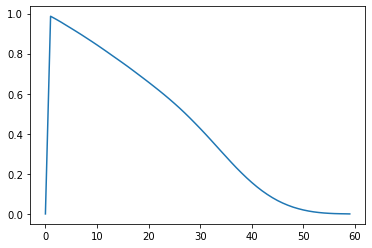

In [11]:
# Population during the entire simulation period
plt.plot(np.mean(life, axis = 1))

In [12]:
def quantileForPeopleWholive(attribute, quantiles = [0.25, 0.5, 0.75]):
    qList = []
    for i in range(T_max):
        if len(np.where(life[i,:] == 1)[0]) == 0:
            qList.append(np.array([0] * len(quantiles)))
        else:
            qList.append(np.quantile(attribute[i, np.where(life[i,:] == 1)], q = quantiles))
    return np.array(qList)
        
def meanForPeopleWholive(attribute):
    means = []
    for i in range(T_max):
        if len(np.where(life[i,:] == 1)[0]) == 0:
            means.append(np.array([0]))
        else:
            means.append(np.mean(attribute[i, np.where(life[i,:] == 1)]))
    return np.array(means)

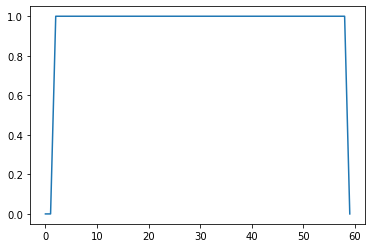

In [13]:
# plot participation ratio
plt.plot(meanForPeopleWholive(participation))

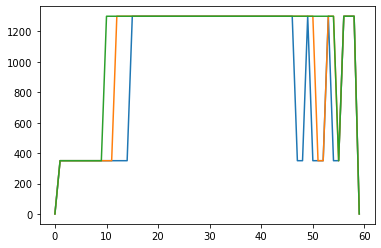

In [14]:
# plot the 0.25, 0.5, 0.75 quantiles of hConsumption
plt.plot(quantileForPeopleWholive(hConsumption))

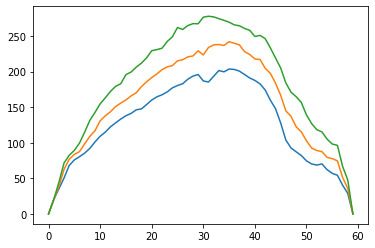

In [15]:
# plot the 0.25, 0.5, 0.75 quantiles of wealth
plt.plot(quantileForPeopleWholive(wealth))

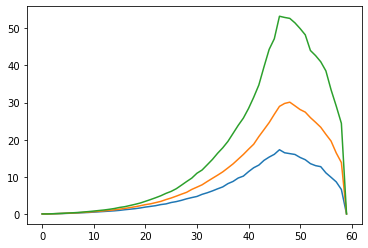

In [16]:
# plot the 0.25, 0.5, 0.75 quantiles of wealth
plt.plot(quantileForPeopleWholive(rFund))

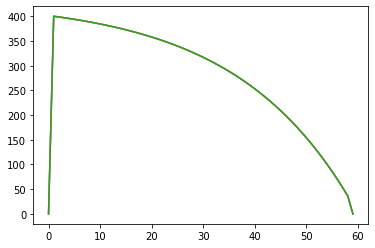

In [17]:
# plot the 0.25, 0.5, 0.75 quantiles of wealth
plt.plot(quantileForPeopleWholive(Mortgage))

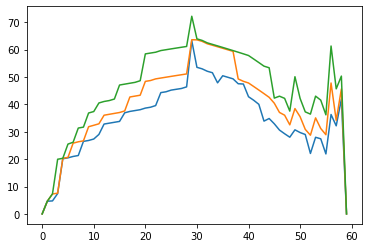

In [18]:
# plot the 0.25, 0.5, 0.75 quantiles of wealth
plt.plot(quantileForPeopleWholive(consumption))

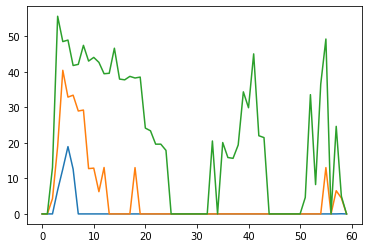

In [19]:
# plot the 0.25, 0.5, 0.75 quantiles of wealth
plt.plot(quantileForPeopleWholive(bond))

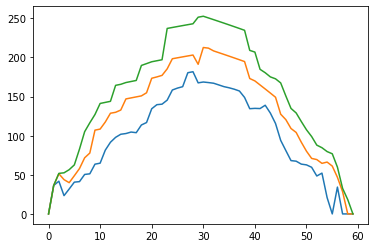

In [20]:
# plot the 0.25, 0.5, 0.75 quantiles of wealth
plt.plot(quantileForPeopleWholive(stock))

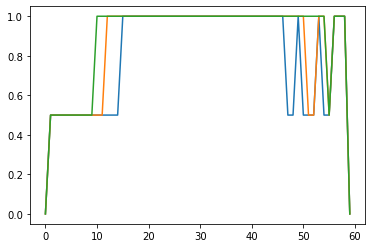

In [21]:
# plot the 0.25, 0.5, 0.75 quantiles of wealth
plt.plot(quantileForPeopleWholive(hPer))

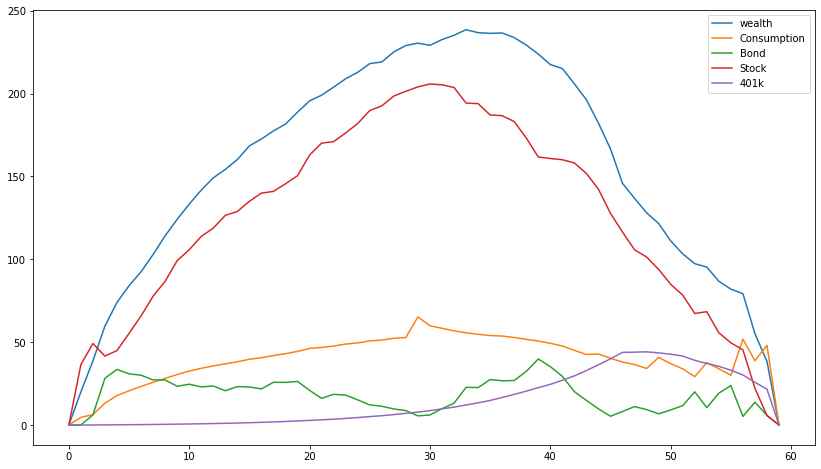

In [22]:
# plot the 0.25, 0.5, 0.75 quantiles of wealth
plt.figure(figsize = [14,8])
plt.plot(meanForPeopleWholive(wealth), label = "wealth")
plt.plot(meanForPeopleWholive(consumption), label = "Consumption")
plt.plot(meanForPeopleWholive(bond), label = "Bond")
plt.plot(meanForPeopleWholive(stock), label = "Stock")
plt.plot(meanForPeopleWholive(rFund), label = "401k")
plt.legend()